### Insights from Reviewing Data Dict

* The following fields are depracated or no longer supported and should be excluded from the model so it doesn't cause breaking of the pipeline in the future. networkDomain, networkLocation, isMobile

This also points to a type of drift that we should make our pipelines / API resilient to

Additional Features we could capture which were not in the original consideration set for the conversion model include (per user)
* Number of TrueDirect sessions, count of non-null sessions in the IsTrueDirect column

* Number of adwordsSessions (sessions which had some ad interaction), count of how many visits for which at least one of the adwords or adcontent columns are populated (leakage?)

* PCA components of source feature, could apply the same to country feature --> first create sparse count of referral source per user. THEN perform PCA on the per user dataset. May need to standardize once it's tallied up this way, before creating components. Whatever conclusion we reach from applying this to the training set would need to be applied to the validation and test set as well, but cannot create components altogether as this risks data leakage

Did PCA, but i can look into FAMD more if time allows.

https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210

https://towardsdatascience.com/factor-analysis-of-mixed-data-5ad5ce98663c

### Attempt at PCA on Source Feature

In [1]:
import pandas as pd

In [2]:
gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_15857/3136096564.py:1: DtypeWarning: Columns (2,54) have mixed types. Specify dtype option on import or set low_memory=False.
  gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")


In [3]:
source_df = pd.DataFrame.copy(gstore['source'])

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [5]:
encoder = OneHotEncoder(sparse_output= False)

In [6]:
encoded_source = encoder.fit_transform(source_df.to_numpy().reshape(-1, 1))

In [7]:
encoded_df = pd.DataFrame(encoded_source, index=source_df.index, columns=encoder.get_feature_names_out())

In [9]:
# going from 380 potential sources, and source is a fully populated column
pca = PCA(n_components=20)
pca.fit(encoded_df)

PCA(n_components=20)

In [10]:
pca.explained_variance_ratio_

array([0.46175465, 0.26118638, 0.12723651, 0.04128312, 0.02515321,
       0.01346282, 0.00810481, 0.00647967, 0.00518889, 0.00481465,
       0.00407228, 0.00342697, 0.00317968, 0.00293208, 0.00264091,
       0.00237903, 0.00236165, 0.00230856, 0.00226216, 0.00173574])

In [11]:
import matplotlib.pyplot as plt
import numpy as np

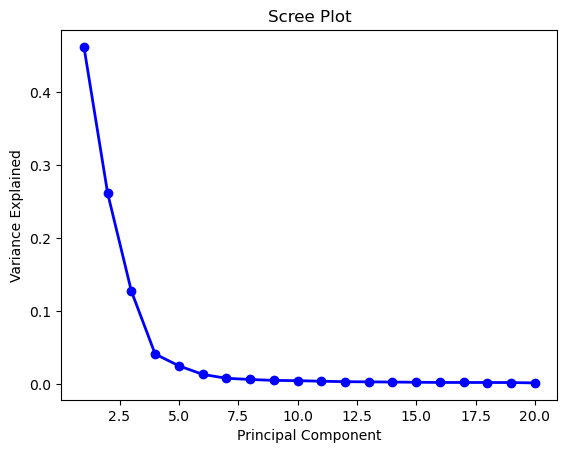

In [12]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [8]:
# elbow is at 3 components. note, after this is aggregated to user level and then standardized, elbow may move
pca = PCA(n_components=3)
X_source_pca = pca.fit_transform(encoded_df)
# I believe we'd need to do this for train and test separately to not have data leakage through the PCA??

In [9]:
n_components = X_source_pca.shape[1]  # Get the number of components
column_names = [f"PC_Source_{i}" for i in range(n_components)]  
# Create the DataFrame with the transformed data and column names
X_source_df = pd.DataFrame(data=X_source_pca, columns=column_names, index=encoded_df.index)

In [23]:
# could then stitch that^ back to the original dataset

## Rough Work, Can Disregard. I'll clean up before submission 

In [3]:
gstore.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'continent', 'subContinent', 'country', 'region', 'metro', 'city',
       'cityId', 'networkDomain', 'latitude', 'longitude', 'networkLocation',
       'browser', 'browserVersion', 'browserSize', 'operatingSystem',
       'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding',
       'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo',
       'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors',
       'screenResolution', 'deviceCategory', 'visits', 'hits', 'pageviews',
       'bounces', 'newVisits', 'transactionRevenue', 'campaign', 'source',
       'medium', 'keyword', 'adwordsClickInfo.criteriaParameters',
       'isTrueDirect', 'referralPath', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd',
       '

In [4]:
print(len(gstore['networkDomain'].unique()))

28064


In [5]:
gstore['networkDomain'].head(50)

0             ttnet.com.tr
1              dodo.net.au
2          unknown.unknown
3          unknown.unknown
4          unknown.unknown
5            fastwebnet.it
6          unknown.unknown
7           bigpond.net.au
8                  spar.at
9                chello.nl
10      airtelbroadband.in
11              wanadoo.fr
12         unknown.unknown
13         unknown.unknown
14      cabotelecom.com.br
15         unknown.unknown
16           igmholding.nl
17               nerim.net
18         unknown.unknown
19      phonevision.com.ar
20                tpnet.pl
21        live-servers.net
22         unknown.unknown
23           asianet.co.th
24              cbn.net.id
25              hafele.com
26          coltfrance.com
27            broadband.hu
28         unknown.unknown
29         unknown.unknown
30          threembb.co.uk
31                 tdc.net
32               hinet.net
33               (not set)
34              rambler.ru
35             billa.co.at
36               (not set)
3

In [6]:
unknown_count = gstore[gstore['networkDomain'] == 'unknown.unknown'].shape[0]
total_count = gstore.shape[0]
proportion = unknown_count / total_count

print("Proportion of records with 'unknown.unknown' in networkDomain column:", proportion)

Proportion of records with 'unknown.unknown' in networkDomain column: 0.16160406704786018


In [7]:
print(len(gstore['source'].unique()))

380


In [8]:
gstore.head(50)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,continent,subContinent,...,adwordsClickInfo.criteriaParameters,isTrueDirect,referralPath,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,adContent,campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Asia,Western Asia,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Oceania,Australasia,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Europe,Southern Europe,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,Asia,Southeast Asia,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Europe,Northern Europe,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Organic Search,20160902,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,1472807194,Europe,Southern Europe,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Organic Search,20160902,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,1472817241,Asia,Southern Asia,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Organic Search,20160902,537222803633850821,537222803633850821_1472812602,Not Socially Engaged,1472812602,1,1472812602,Oceania,Australasia,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Organic Search,20160902,4445454811831400414,4445454811831400414_1472805784,Not Socially Engaged,1472805784,1,1472805784,Europe,Western Europe,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Organic Search,20160902,9499785259412240342,9499785259412240342_1472812272,Not Socially Engaged,1472812272,1,1472812272,Europe,Western Europe,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(gstore['isTrueDirect'].notnull().sum())

274005


In [10]:
print(gstore['isTrueDirect'].notnull().sum() / gstore.shape[0])

0.3032192666875449


In [11]:
gstore['latitude'].isnull().sum()

0

In [12]:
gstore['longitude'].isnull().sum()

0

In [3]:
print(len(gstore['mobileInputSelector'].unique()))

1


In [4]:
gstore['mobileInputSelector'].value_counts()

not available in demo dataset    903653
Name: mobileInputSelector, dtype: int64

In [5]:
gstore[ 'adwordsClickInfo.page'].head(50)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
42   NaN
43   NaN
44   NaN
45   NaN
46   NaN
47   NaN
48   NaN
49   NaN
Name: adwordsClickInfo.page, dtype: float64

In [6]:
gstore[ 'source'].head(50)

0                 google
1                 google
2                 google
3                 google
4                 google
5                 google
6                 google
7                 google
8                 google
9                 google
10                google
11                google
12                google
13                google
14                google
15                 baidu
16                google
17                google
18                google
19                google
20                google
21                 baidu
22                google
23                google
24                google
25                google
26                google
27                google
28    googleweblight.com
29                google
30                google
31                google
32                google
33                google
34                google
35                google
36                google
37                google
38                google
39                google


In [7]:
gstore['source'].value_counts()

google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
                                                      ...  
google.se                                                 1
0.shared.bow.cat2.ads-bow.vu.borg.google.com:9883         1
myaccount.google.com                                      1
0.shared.bow.cat2.ads-bow.tg.borg.google.com:9864         1
0.shared.bow.cat2.ads-bow.yw.borg.google.com:9898         1
Name: source, Length: 380, dtype: int64

In [8]:
gstore['city'].value_counts()

not available in demo dataset    508229
Mountain View                     40884
(not set)                         34262
New York                          26371
San Francisco                     20329
                                  ...  
Douglasville                          5
San Salvador                          5
Daly City                             4
Boise                                 3
Bozeman                               3
Name: city, Length: 649, dtype: int64

In [9]:
gstore['region'].value_counts()

not available in demo dataset    508229
California                       107495
(not set)                         27827
New York                          26433
England                           13198
                                  ...  
Leiria District                       6
Assam                                 6
Kumamoto Prefecture                   5
San Salvador Department               5
Montana                               3
Name: region, Length: 376, dtype: int64

In [10]:
gstore['country'].value_counts()

United States            364744
India                     51140
United Kingdom            37393
Canada                    25869
Vietnam                   24598
                          ...  
St. Pierre & Miquelon         1
Anguilla                      1
American Samoa                1
Åland Islands                 1
St. Barthélemy                1
Name: country, Length: 222, dtype: int64

In [13]:
cns = gstore[gstore['country'] == '(not set)'].shape[0]
print(cns)

1468


In [ ]:
unknown_count = gstore[gstore['networkDomain'] == 'unknown.unknown'].shape[0]
total_count = gstore.shape[0]
proportion = unknown_count / total_count

print("Proportion of records with 'unknown.unknown' in networkDomain column:", proportion)

In [11]:
gstore['continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: continent, dtype: int64